In [89]:
"""
amm: Dictionary with Key = asset, Value = amt of asset
trade: Tuple with (Asset to sell, asset to collect, amt of asset to sell) 
    - from the AMMs pov
fee_type: fee structure to be implemented on trade
"""

'\namm: Dictionary with Key = asset, Value = amt of asset\ntrade: Tuple with (Asset to sell, asset to collect, amt of asset to sell) \n    - from the AMMs pov\nfee_type: fee structure to be implemented on trade\n'

In [88]:
import math
import numpy as np
import random
from scipy.stats import truncnorm
from scipy import integrate
import matplotlib.pyplot as plt

In [90]:
def quote(amm, trade):
    """
    AB/L^2 = 1 doesn't actually need the bisection solver as there will always be a closed form solution
    These are the closed form solutions for each trade 
    """
    if trade[0] == "L":
        return np.sqrt(amm["A"] * amm["B"])
    elif trade[0] == "A":
        new_A = (amm["L"]**2) / amm["B"]
        new_B = (amm["L"]**2) / new_A
        return new_A, new_B
    else:
        new_B = (amm["L"]**2) / amm["A"]
        new_A = (amm["L"]**2) / new_B
        return new_B, new_A

In [91]:
def fee_calc(amm, trade, type):
    
    if type == "percentage":
        return 0.003
    
    elif type == "tiered":
        mean, sigma = 10, 5
        if trade[2] < (mean - sigma): return 0.0005
        elif trade[2] > (mean +  sigma): return 0.01
        return 0.003
    
    elif type == "naive triangle": 
        mean, sigma = 10, 5
        if trade[2] > (mean - sigma) and trade[2] < (mean + sigma): return 0.003
        elif trade[2] < (mean - sigma): return 0.01
        return 0.0005
    
    elif type == "triangle":
        # get delta x to set upper limit
        delta_x = amm[trade[0]] - quote(amm, trade)[0]
        delta_y = quote(amm, trade)[1] - amm[trade[1]]
        f, m, X, Y = 0.003, -1, amm[trade[0]], amm[trade[1]]
        
        delta_val = ((Y + delta_y) / (X - max(f, delta_x))) - (Y / X)
        def func(x):
            return f + m * x
    
        try:
            return (f * delta_val) + (0.5 * m * (delta_val)**2) * 100000
        except ZeroDivisionError:
            return 0

In [92]:
def trade_calc(amm, trade, fee_type):
    # Add the amount of assets given to amm to AMM
    amm[trade[1]] += trade[2]
    
    # Calculate the fees to be assessed on the trade
    if fee_type == "triangle": 
        fee = fee_calc(amm, trade, "triangle")
        amm[trade[0]] = quote(amm, trade)[0] - fee
    else: 
        fee = (quote(amm, trade)[0] - amm[trade[0]]) * fee_calc(amm, trade, fee_type)
        amm[trade[0]] = quote(amm, trade)[0] * (1 - fee_calc(amm, trade, fee_type))
    
    # Update amm for asset going out 
        # This could be wrong, let me know
    return fee, amm

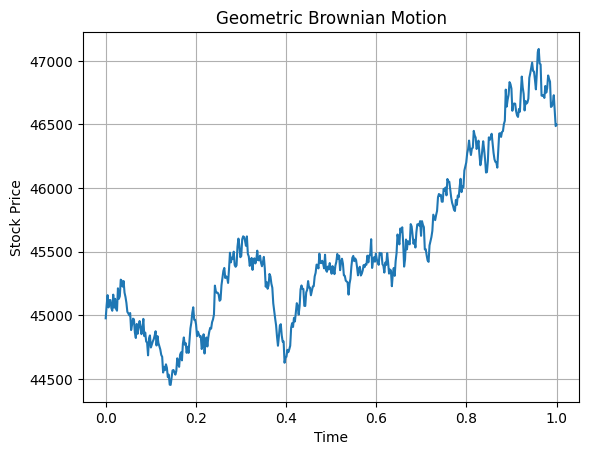

In [93]:
def geometric_brownian_motion(mu, sigma, S0, T, N, dt):
    """
    Generate geometric brownian motion.

    Parameters:
        mu (float): Drift coefficient.
        sigma (float): Diffusion coefficient.
        S0 (float): Initial value.
        T (float): Terminal time.
        N (int): Number of time steps.
        dt (float): Time step size.

    Returns:
        numpy.ndarray: Simulated GBM path.
    """
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)  # Standard Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W 
    S = S0 * np.exp(X)  # Geometric Brownian motion
    return S

# Parameters
mu = 0  # Drift coefficient
sigma = 0.0351  # Diffusion coefficient
S0 = 45000  # Initial value
T = 1.0  # Terminal time
N = 480  # Number of time steps
dt = T / N  # Time step size

# Generate GBM path
gbm_path = geometric_brownian_motion(mu, sigma, S0, T, N, dt)

# Plot GBM path
plt.plot(np.linspace(0, T, N), gbm_path)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Geometric Brownian Motion')
plt.grid(True)
plt.show()


In [94]:
AMM = {
    "A": 10000,
    "B": 10000,
    "L": 10000
}

mean = 10  # Mean
sigma = 5  # Standard deviation
a = (0 - mean) / sigma  # Lower bound
b = (10000 - mean) / sigma  # Upper bound

# Create a frozen distribution object
trade_sizes = truncnorm(a, b, loc=mean, scale=sigma)

values_list = (trade_sizes.rvs(size=480)).tolist()

exchange_rate = []
assets = ["A", "B"]
choices = [0, 1]
feesA = []
feesB = []
ratiosA = []
ratiosB = []
vols = []
unrealized_rtrns, unrealized_vol = [], []

for j in range(1000):
    trade_sizes = truncnorm(a, b, loc=mean, scale=sigma)
    values_list = (trade_sizes.rvs(size=480)).tolist()
    underlying = geometric_brownian_motion(0, 0.0351, 2800, 1.0, 480, T/N)
    port_val = []

    fees_collected = {
    "A": 0,
    "B": 0,
    "FA": 0,
    "FB": 0
    }
    
    for i, item in enumerate(values_list):
        traded = random.choice(choices)
        trade = (assets[traded], assets[(traded + 1) % len(assets)], item)
        exchange_rate.append(AMM["A"] / AMM["B"])
        fee, AMM = trade_calc(AMM, trade, "triangle")
        fees_collected[assets[traded]] += (fee * ((AMM["A"] / AMM[assets[traded]]) * underlying[i]))
        fees_collected["F" + assets[traded]] += 0.003
        port_val.append(((AMM["A"]/AMM["L"]) * underlying[i]) + (fees_collected["A"] + fees_collected["B"]))

    feesA.append(-1 * fees_collected["A"])
    feesB.append(-1 * fees_collected["B"])
    ratiosA.append((((-1 * fees_collected["A"] - fees_collected["FA"]) / np.std(exchange_rate)) / 10000))
    ratiosB.append((((-1 * fees_collected["B"] - fees_collected["FB"]) / np.std(exchange_rate)) / 10000))
    vols.append(np.std(exchange_rate) * 100)
    unrealized_rtrns.append((port_val[-1] / port_val[0]) - 1)
    unrealized_vol.append(np.std(port_val))

In [96]:
print(feesA)

[47179.48691750724, 41225.25399903458, 45296.74613830558, 42289.820395456554, 52710.1599078701, 47704.90918556157, 47069.76644644264, 47143.17847486557, 49192.16210533841, 47168.0992971011, 48671.815992764605, 46507.63811362217, 44553.59222678091, 41427.947151656444, 46522.62219091447, 47227.98224341211, 46043.337959445555, 38667.823976610634, 47397.32565876847, 42372.0868754693, 42752.64204589081, 52662.36500499927, 45275.30203617656, 42066.962202873634, 44465.454299201614, 44040.220378313454, 46542.506177625066, 50166.6370277698, 44718.809220261246, 43359.61544417614, 40246.48179172417, 37987.922647727566, 42204.20928625968, 37152.333251415854, 48394.78270692215, 44058.27277270469, 43483.5572813888, 43595.48251497205, 45371.65968477978, 44142.85170947804, 48054.007719485475, 39218.706604927924, 42313.835102465564, 34214.65981769525, 38644.24877554188, 41834.368118284125, 39484.275656096856, 40907.364606859504, 40594.445059737685, 44583.35551758759, 42574.82554459547, 41181.4126948930

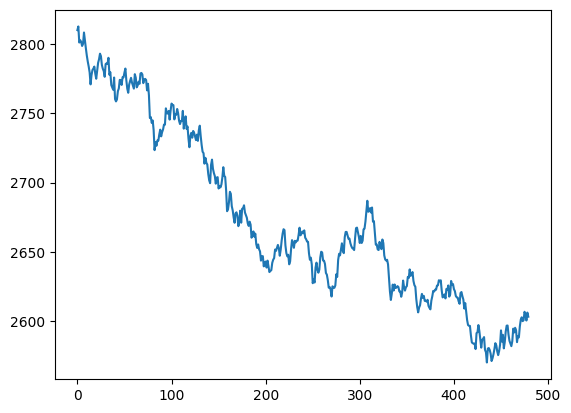

In [84]:

plt.plot(unrealized[-480:])

In [85]:
print(np.mean(unrealized_vol))
print(np.mean(unrealized_rtrns))

23107.080560045983
26.874848376265632


In [86]:
for i in range(len(exchange_rate)):
    if i % 100 == 0:
        print("Exchange rate after", i, "iterations:", exchange_rate[i])

Exchange rate after 0 iterations: 1.0
Exchange rate after 100 iterations: 0.9865502298967297
Exchange rate after 200 iterations: 0.9812748860487335
Exchange rate after 300 iterations: 0.938542160458284
Exchange rate after 400 iterations: 0.9541923669761991
Exchange rate after 500 iterations: 0.921957744161832
Exchange rate after 600 iterations: 0.9313760164052736
Exchange rate after 700 iterations: 0.9172418101078655
Exchange rate after 800 iterations: 0.9723536438963045
Exchange rate after 900 iterations: 0.9660169582940491
Exchange rate after 1000 iterations: 0.9420979496122459
Exchange rate after 1100 iterations: 0.9771307395963982
Exchange rate after 1200 iterations: 0.9959425278960201
Exchange rate after 1300 iterations: 1.0124237472965647
Exchange rate after 1400 iterations: 1.016837628507093
Exchange rate after 1500 iterations: 1.011154928211634
Exchange rate after 1600 iterations: 0.9860120919285993
Exchange rate after 1700 iterations: 1.0027542315184923
Exchange rate after 180

In [160]:
# 0.3% fee on all trades
print("Fees Collected A:", round(np.mean(feesA), 2))
print("Fees Collected B:", round(np.mean(feesB), 2))
print("Percentage A:", round(np.mean(ratiosA), 4))
print("Percentage B:", round(np.mean(ratiosB), 4))
print("Pool Volatility:", round(np.mean(vols), 2), "%")

Fees Collected A: 296.14
Fees Collected B: 296.41
Percentage A: 0.5821
Percentage B: 0.5827
Pool Volatility: 4.86 %


In [313]:
# Tiered Fees
print("Fees Collected A:", round(np.mean(feesA), 2))
print("Fees Collected B:", round(np.mean(feesB), 2))
print("Percentage A:", round(np.mean(ratiosA), 4))
print("Percentage B:", round(np.mean(ratiosB), 4))
print("Pool Volatility:", round(np.mean(vols), 2), "%")

Fees Collected A: -469.46
Fees Collected B: -472.21
Percentage A: -0.4078
Percentage B: -0.4101
Pool Volatility: 11.89 %


In [156]:
# Inverse Tiered Fees
print("Fees Collected A:", round(np.mean(feesA), 2))
print("Fees Collected B:", round(np.mean(feesB), 2))
print("Ratio A:", round(np.mean(ratiosA), 4))
print("Ratio B:", round(np.mean(ratiosB), 4))
print("Pool Volatility:", round(np.mean(vols), 2), "%")

Fees Collected A: 504.4
Fees Collected B: 504.86
Ratio A: 0.5798
Ratio B: 0.5807
Pool Volatility: 8.48 %


In [8]:
# Triangle Fees
print(fees_collected["FA"])
print("Fees Collected A:", round(np.mean(feesA), 2))
print("Fees Collected B:", round(np.mean(feesB), 2))
print("Ratio A:", round(np.mean(ratiosA), 4))
print("Ratio B:", round(np.mean(ratiosB), 4))
print("Pool Volatility:", round(np.mean(vols), 2), "%")

15.063000000000459
Fees Collected A: 321.94
Fees Collected B: 326.08
Ratio A: 0.6332
Ratio B: 0.6417
Pool Volatility: 4.88 %


Text(0.5, 1.0, 'Fees Collected Using Different Fee Structures')

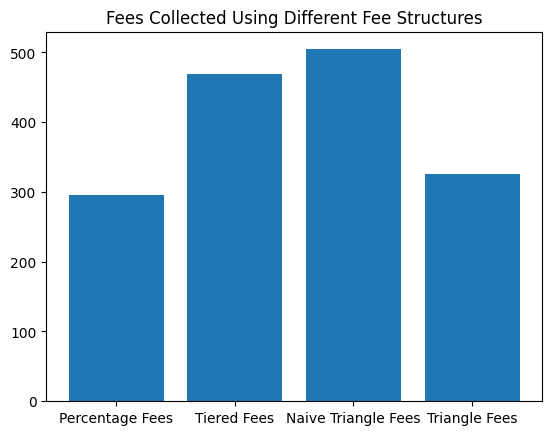

In [353]:
plt.bar(["Percentage Fees", "Tiered Fees", "Naive Triangle Fees", "Triangle Fees"], 
        [296.14, 469.24, 504.4, 325.53])
plt.title("Fees Collected Using Different Fee Structures")

Text(0.5, 1.0, 'Risk Adjusted Scores of Each Fee Structure')

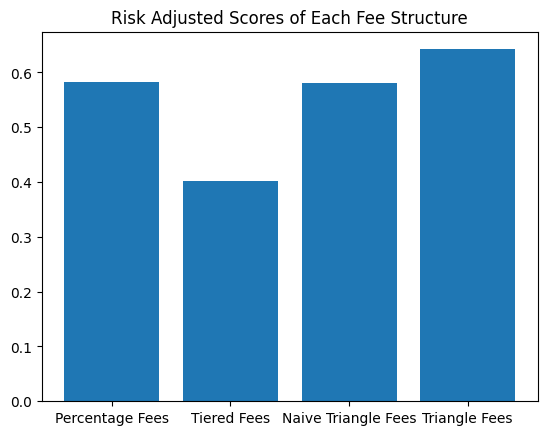

In [354]:
plt.bar(["Percentage Fees", "Tiered Fees", "Naive Triangle Fees", "Triangle Fees"], 
        [0.5821, 0.4021, 0.5798, 0.6421])
plt.title("Risk Adjusted Scores of Each Fee Structure")

Text(0.5, 1.0, 'Percent Pool Volatility for Each Fee Structure')

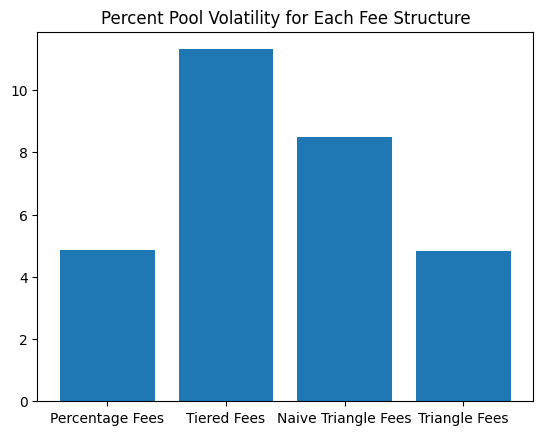

In [355]:
plt.bar(["Percentage Fees", "Tiered Fees", "Naive Triangle Fees", "Triangle Fees"], 
        [4.86, 11.31, 8.48, 4.84])
plt.title("Percent Pool Volatility for Each Fee Structure")